# LSTM Modeling

## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error as mse

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

import os
import keras

os.environ["KERAS_BACKEND"] = "torch"

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print (x)
else:
    print ("MPS device not found.")
    
torch.mps.set_per_process_memory_fraction(0.0)
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
tensor([1.], device='mps:0')


## Load Dataset

In [2]:
df = pd.read_csv("../dataset/Indeks Standar Pencemar Udara di Provinsi DKI Jakarta 2021.csv")

df['tanggal'] = pd.to_datetime(df['tanggal'])
df.set_index('tanggal', inplace=True)
df = df[['pm10']]

df.head()

,pm10
tanggal,
2021-01-01,43
2021-01-02,58
2021-01-03,64
2021-01-04,50
2021-01-05,59


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2021-01-01 to 2021-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   pm10    365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB


## Time Plot

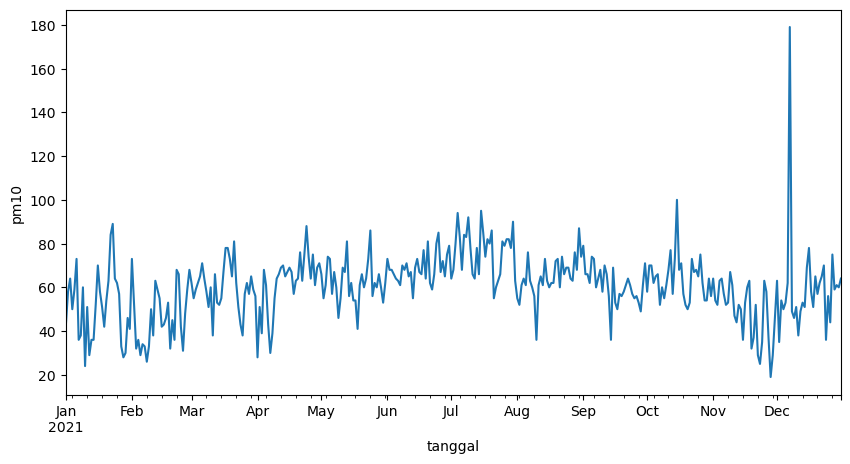

In [4]:
df["pm10"].plot(figsize = (10,5))
plt.ylabel("pm10")
plt.show()

## Decomposition

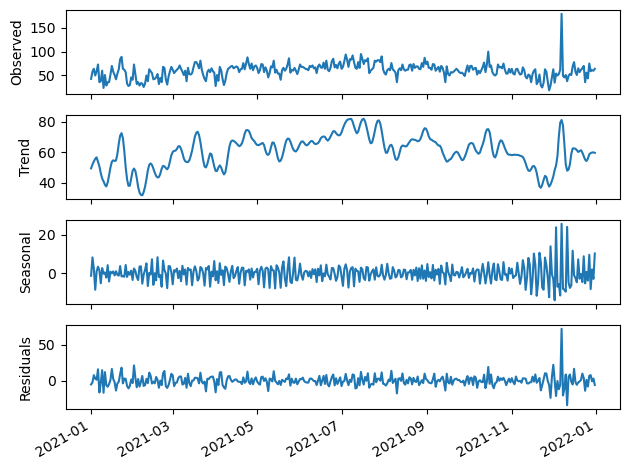

In [5]:
advanced_decomposition = STL(df["pm10"], period=4).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

## Splitting Data

In [6]:
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
train_data, test_data = df[:train_size], df[train_size:]

In [7]:
dataset_train = train_data['pm10'].values
dataset_train = np.reshape(dataset_train, (-1,1))

dataset_test = test_data['pm10'].values
dataset_test = np.reshape(dataset_test, (-1,1))

## Normalization

In [8]:
scaler = StandardScaler()

scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.fit_transform(dataset_test)

## Create Time Series Dataset

In [9]:
time_step_train = 50
time_step_test = 30

def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:i+time_step])
        Y.append(dataset[i+1:i+time_step+1])
    return np.array(X), np.array(Y)

X_train, y_train = create_dataset(scaled_train, time_step_train)
X_test, y_test = create_dataset(scaled_test, time_step_test)

In [10]:
X_train.shape, y_train.shape

((242, 50, 1), (242, 50, 1))

In [11]:
X_test.shape, y_test.shape

((43, 30, 1), (43, 30, 1))

## Convert to Tensor

In [12]:
X_train = torch.tensor(X_train).float().to(device)
y_train = torch.tensor(y_train).float().to(device)
X_test = torch.tensor(X_test).float().to(device)
y_test = torch.tensor(y_test).float().to(device)

In [13]:
batch_size = 8
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
 
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Modeling

In [14]:
class LSTMModel(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers): 
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
 
    def forward(self, x): 
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

In [15]:
input_size = 1
num_layers = 2
hidden_size = 64
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers).to(device)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [16]:
num_epochs = 50
train_hist =[]
test_hist =[]

for epoch in range(num_epochs):
    total_loss = 0.0
    
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        total_loss += loss.item()
    
    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)
 
    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0
 
        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)
 
            total_test_loss += test_loss.item()
    
        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)
        
    if (epoch+1)%10==0:
        print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

Epoch [10/50] - Training Loss: 0.4102, Test Loss: 1.3030
Epoch [20/50] - Training Loss: 0.1779, Test Loss: 1.4698
Epoch [30/50] - Training Loss: 0.1076, Test Loss: 1.4660
Epoch [40/50] - Training Loss: 0.0869, Test Loss: 1.4262
Epoch [50/50] - Training Loss: 0.0783, Test Loss: 1.4229


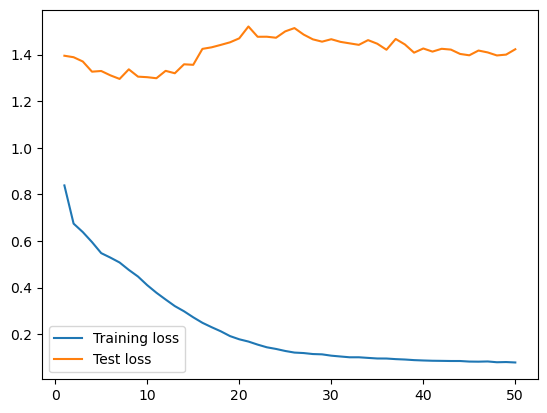

In [17]:
x = np.linspace(1, num_epochs, num_epochs)
plt.plot(x, train_hist, scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

In [18]:
num_forecast_steps = 30
 
sequence_to_plot = X_test.squeeze().cpu().numpy()
 
historical_data = sequence_to_plot[-1]
print(historical_data.shape)
 
forecasted_values = []
 
with torch.no_grad():
    for _ in range(num_forecast_steps*2):
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
 
        forecasted_values.append(predicted_value[0])
 
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value.item()

last_date = test_data.index[-1]
 
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)
 
combined_index = test_data.index.append(future_dates)

(30,)


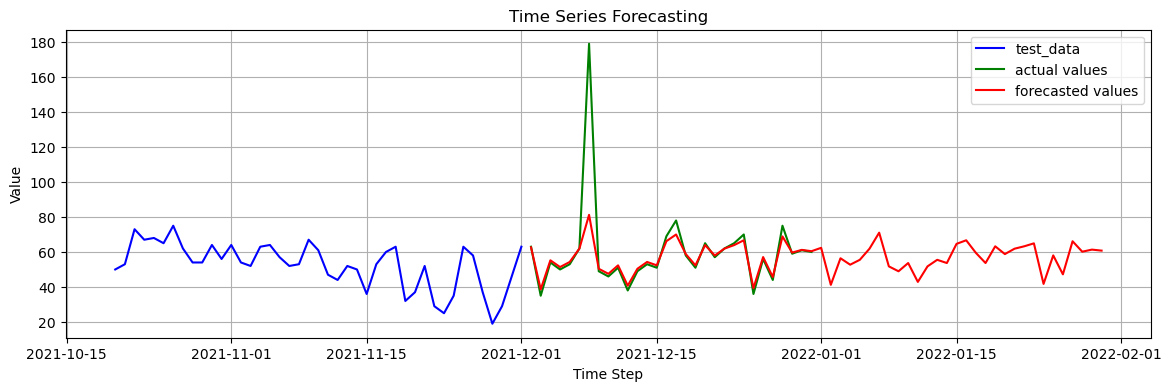

In [19]:
plt.rcParams['figure.figsize'] = [14, 4] 

plt.plot(test_data.index[-100:-30], test_data['pm10'][-100:-30], label = "test_data", color = "b") 
original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0)).flatten() 
 
plt.plot(test_data.index[-30:], original_cases, label='actual values', color='green') 
 
forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten() 
plt.plot(combined_index[-60:], forecasted_cases, label='forecasted values', color='red')  
 
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)

## Predict New Data

In [20]:
def predict(model, data):
    data = data.to(device)
    
    output = model(data).detach().cpu().numpy()
    output = scaler.inverse_transform(output.reshape(-1,1))  
    
    return output[0].item()

In [21]:
new_data = np.arange(80, 201, 1)

In [22]:
new_data = np.reshape(new_data, (-1,1))
scaled_new_data = scaler.fit_transform(new_data)
scaled_new_data = torch.tensor(scaled_new_data, dtype=torch.float32)

In [23]:
prediksi = predict(model, scaled_new_data)

In [24]:
prediksi

96.45159912109375